In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [3]:
# Definimos los parámetros básicos del preprocesamiento de imágenes
IMG_SIZE = (150, 150)        # Tamaño al que se redimensionarán todas las imágenes (ancho x alto)
BATCH_SIZE = 32              # Cantidad de imágenes que se procesarán en cada lote (batch)
DATASET_DIR = "images"       # Ruta donde se encuentra la carpeta principal con las subcarpetas de clases

# Creamos un generador de datos para realizar *data augmentation* y escalar los valores de píxeles
datagen = ImageDataGenerator(
    rescale=1./255,           # Escala los valores de los píxeles al rango [0, 1] dividiendo por 255
    validation_split=0.2      # Separa el 20% de los datos para validación y el 80% restante para entrenamiento
)

# Generador para cargar automáticamente las imágenes de entrenamiento desde las carpetas
train_generator = datagen.flow_from_directory(
    DATASET_DIR,              # Directorio base que contiene una subcarpeta por clase
    target_size=IMG_SIZE,     # Redimensiona las imágenes al tamaño especificado
    batch_size=BATCH_SIZE,    # Número de imágenes a procesar por lote
    class_mode='categorical', # Indica que se trata de una clasificación multiclase (una etiqueta por clase)
    subset='training',        # Especifica que este generador se usará para el subconjunto de entrenamiento
    shuffle=True              # Mezcla las imágenes en cada época para evitar que el modelo aprenda un orden
)

# Generador para cargar automáticamente las imágenes de validación
val_generator = datagen.flow_from_directory(
    DATASET_DIR,              # Mismo directorio base que el del entrenamiento
    target_size=IMG_SIZE,     # Redimensiona igual que en entrenamiento para mantener consistencia
    batch_size=BATCH_SIZE,    # Tamaño de lote también igual que en entrenamiento
    class_mode='categorical', # También se usa clasificación multiclase para validación
    subset='validation',      # Especifica que este generador se usará para el subconjunto de validación
    shuffle=True              # También se mezclan para garantizar aleatoriedad en cada época
)



Found 5619 images belonging to 4 classes.
Found 1404 images belonging to 4 classes.


In [5]:
# Definimos un modelo secuencial, lo que significa que las capas se apilan una tras otra en orden
model = Sequential([
    # Primera capa convolucional:
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    # - Aplica 32 filtros de tamaño 3x3 a la imagen de entrada
    # - Usa la función de activación ReLU para introducir no linealidad
    # - input_shape indica que las imágenes de entrada tienen tamaño 150x150 y 3 canales (RGB)

    MaxPooling2D(pool_size=(2, 2)),
    # - Reduce la dimensionalidad tomando el valor máximo en cada región 2x2
    # - Ayuda a disminuir el tamaño de la imagen y reduce el coste computacional

    # Segunda capa convolucional:
    Conv2D(64, (3, 3), activation='relu'),
    # - Ahora aplica 64 filtros, incrementando la profundidad de las características extraídas

    MaxPooling2D(pool_size=(2, 2)),
    # - Nuevamente reduce la dimensionalidad mediante max pooling

    # Tercera capa convolucional:
    Conv2D(128, (3, 3), activation='relu'),
    # - Aumenta aún más la profundidad, permitiendo capturar características más complejas

    MaxPooling2D(pool_size=(2, 2)),
    # - Aplica una tercera reducción de dimensionalidad

    # Aplanamos la salida de las capas convolucionales para conectarlas con capas densas
    Flatten(),

    # Capa Dropout para evitar sobreajuste:
    Dropout(0.5),
    # - Desactiva aleatoriamente el 50% de las neuronas durante el entrenamiento
    # - Esto ayuda a que el modelo no dependa demasiado de ciertas conexiones

    # Capa densa oculta:
    Dense(128, activation='relu'),
    # - Capa totalmente conectada con 128 neuronas y activación ReLU

    # Capa de salida:
    Dense(4, activation='softmax')  # 4 clases
    # - Capa de salida con 4 neuronas, una por cada clase
    # - Softmax convierte las salidas en probabilidades que suman 1
])

# Compilamos el modelo antes de entrenarlo
model.compile(
    optimizer=Adam(learning_rate=0.0001),       # Optimizador Adam con una tasa de aprendizaje baja
    loss='categorical_crossentropy',            # Pérdida adecuada para clasificación multiclase
    metrics=['accuracy']                        # Métrica de evaluación: exactitud
)

# Mostramos un resumen del modelo, incluyendo el número de parámetros por capa
model.summary()



C:\Users\fvarg\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
# Entrenamos el modelo con los datos previamente preparados
history = model.fit(
    train_generator,           # Generador que proporciona los datos de entrenamiento por lotes
    epochs=15,                 # Número de veces que el modelo verá todos los datos de entrenamiento
    validation_data=val_generator  # Generador con los datos de validación para evaluar el modelo en cada época
)


C:\Users\fvarg\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 146s 820ms/step - accuracy: 0.5556 - loss: 1.0136 - val_accuracy: 0.7771 - val_loss: 0.5858
Epoch 2/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 77s 439ms/step - accuracy: 0.8031 - loss: 0.5127 - val_accuracy: 0.8689 - val_loss: 0.4091
Epoch 3/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 441ms/step - accuracy: 0.8456 - loss: 0.3912 - val_accuracy: 0.8739 - val_loss: 0.3523
Epoch 4/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 442ms/step - accuracy: 0.8767 - loss: 0.3237 - val_accuracy: 0.8832 - val_loss: 0.3219
Epoch 5/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 443ms/step - accuracy: 0.9075 - loss: 0.2667 - val_accuracy: 0.9103 - val_loss: 0.2690
Epoch 6/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 77s 435ms/step - accuracy: 0.9204 - loss: 0.2175 - val_accuracy: 0.9145 - val_loss: 0.2552
Epoch 7/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 76s 430ms/step - accuracy: 0.9309 - loss: 0.1904 - val_accuracy: 0.9103 - val_loss: 0.2502
Epoch 8/15
176/176 ━━━━━━━━━━━━━━━━━━━━ 77s 437ms/step - accuracy: 0.9489 - loss: 

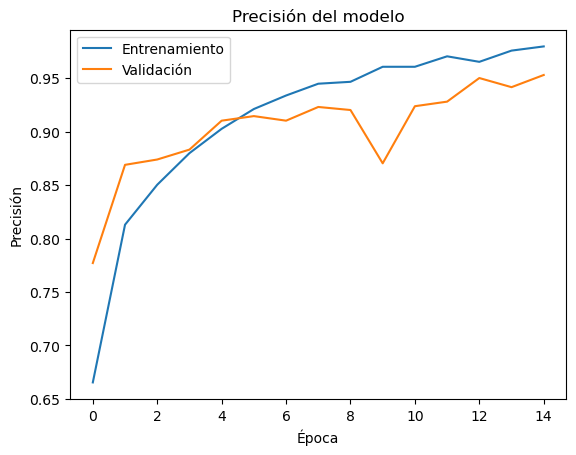

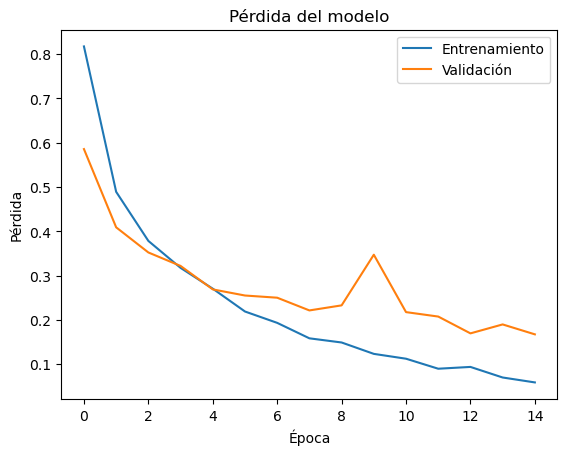

In [9]:
# Gráfico de precisión (accuracy) por época
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Precisión del modelo')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Gráfico de pérdida (loss) por época
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida del modelo')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


In [11]:
# Evaluamos el modelo utilizando el conjunto de validación
val_loss, val_acc = model.evaluate(val_generator)
# - El método evaluate recorre todas las imágenes del generador de validación
# - Devuelve dos valores: la pérdida (loss) y la precisión (accuracy) en ese conjunto
# - Estos valores reflejan qué tan bien está funcionando el modelo con datos que no ha visto antes

# Mostramos la precisión obtenida en validación con dos decimales
print(f'Precisión en validación: {val_acc:.2f}')
# - Esto imprime en pantalla la precisión (accuracy) del modelo en el conjunto de validación
# - Por ejemplo: "Precisión en validación: 0.87" indica que el modelo acertó en el 87% de los casos

44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.9606 - loss: 0.1407
Precisión en validación: 0.95


44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step


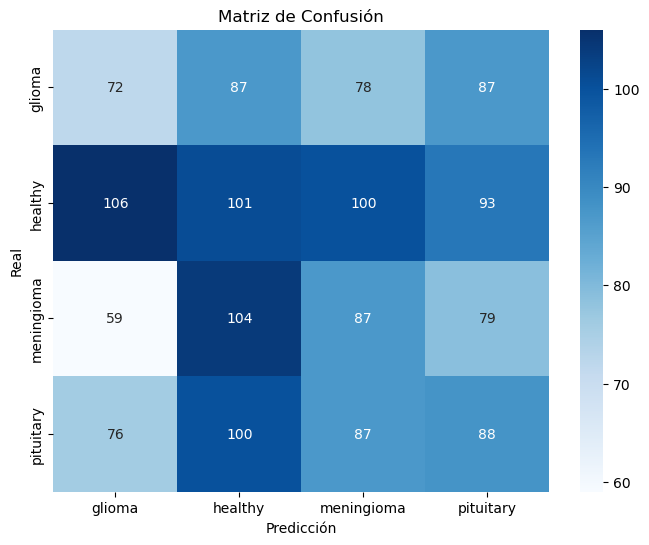

              precision    recall  f1-score   support

      glioma       0.23      0.22      0.23       324
     healthy       0.26      0.25      0.26       400
  meningioma       0.25      0.26      0.26       329
   pituitary       0.25      0.25      0.25       351

    accuracy                           0.25      1404
   macro avg       0.25      0.25      0.25      1404
weighted avg       0.25      0.25      0.25      1404



In [13]:
# Obtener predicciones del modelo sobre el conjunto de validación
y_pred = model.predict(val_generator)
# - Esto genera una matriz de probabilidades, donde cada fila representa una imagen
#   y cada columna la probabilidad estimada para una clase

# Convertimos las probabilidades en clases predichas (la de mayor probabilidad en cada caso)
y_pred_classes = np.argmax(y_pred, axis=1)
# - np.argmax selecciona el índice de la clase con mayor probabilidad en cada fila

# Obtenemos las verdaderas etiquetas del conjunto de validación
y_true = val_generator.classes
# - val_generator.classes contiene los índices reales de clase de cada imagen

# Obtenemos los nombres de las clases, en el mismo orden que los índices utilizados por el generador
class_names = list(val_generator.class_indices.keys())
# - Esto nos permitirá mostrar los nombres reales en lugar de solo números

# Calculamos la matriz de confusión
cm = confusion_matrix(y_true, y_pred_classes)
# - La matriz de confusión permite visualizar cuántas veces el modelo clasificó correctamente
#   y cuántas veces se confundió entre clases

# Visualizamos la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap="Blues")
plt.xlabel('Predicción')   
plt.ylabel('Real')         
plt.title('Matriz de Confusión')  
plt.show()

# Mostramos un reporte detallado con métricas de rendimiento por clase
print(classification_report(y_true, y_pred_classes, target_names=class_names))
# - classification_report incluye:
#     - precision: exactitud de las predicciones positivas
#     - recall: cobertura de las predicciones correctas
#     - f1-score: media armónica entre precisión y recall
#     - support: cantidad de muestras por clase
